## Getting Started

In [1]:
from arcgis.gis import GIS
from arcgis.geoenrichment import enrich
from arcgis.features import FeatureSet
from arcgis.geoenrichment import create_report
from arcgis.geoenrichment import standard_geography_query
import warnings
import pandas as pd

# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

gis = GIS(api_key="YOUR-API-KEY")

## Reading Data

In [2]:
df = pd.read_csv("data/covid19vaccinesbyzipcode_test.csv")
df.head(n=3)

,as_of_date,zip_code_tabulation_area,local_health_jurisdiction,county,vaccine_equity_metric_quartile,vem_source,age12_plus_population,age5_plus_population,tot_population,persons_fully_vaccinated,persons_partially_vaccinated,percent_of_population_fully_vaccinated,percent_of_population_partially_vaccinated,percent_of_population_with_1_plus_dose,up_to_date_count,redacted
0,2021-05-18,94132,San Francisco,San Francisco,3.0,Healthy Places Index Score,29228.4,30558,31436.0,15103.0,2589.0,0.480436,0.082358,0.562794,0,Information redacted in accordance with CA sta...
1,2021-05-18,93402,San Luis Obispo,San Luis Obispo,3.0,Healthy Places Index Score,14419.3,15792,16562.0,7977.0,1177.0,0.481645,0.071066,0.552711,0,Information redacted in accordance with CA sta...
2,2021-05-18,95556,Humboldt,Humboldt,1.0,CDPH-Derived ZCTA Score,429.7,538,598.0,185.0,32.0,0.309365,0.053512,0.362877,0,Information redacted in accordance with CA sta...


<Axes: title={'center': 'Redlands (92373) Vaccination Rate'}, ylabel='% fully vaccinated'>

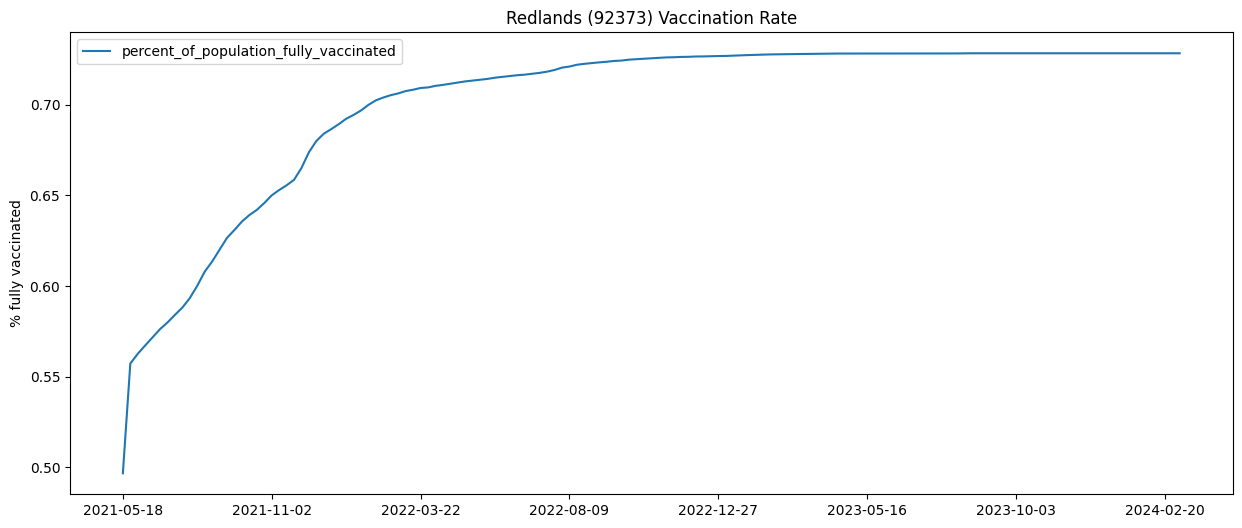

In [3]:
redlands_zip = df[df['zip_code_tabulation_area'] == 92373].copy()
redlands_zip.plot(x='as_of_date',xlabel='', y='percent_of_population_fully_vaccinated', ylabel='% fully vaccinated', figsize=(15,6), title="Redlands (92373) Vaccination Rate")

In [4]:
recent_data = df[df['as_of_date'] == '2024-03-05'].copy()
recent_data = recent_data.reset_index(drop=True)
recent_data = recent_data.sort_values(by=['zip_code_tabulation_area'])
recent_data['vaccination_resistance'] = 1 - recent_data['percent_of_population_fully_vaccinated']
recent_data

,as_of_date,zip_code_tabulation_area,local_health_jurisdiction,county,vaccine_equity_metric_quartile,vem_source,age12_plus_population,age5_plus_population,tot_population,persons_fully_vaccinated,persons_partially_vaccinated,percent_of_population_fully_vaccinated,percent_of_population_partially_vaccinated,percent_of_population_with_1_plus_dose,up_to_date_count,redacted,vaccination_resistance
20,2024-03-05,90001,Los Angeles,Los Angeles,1.0,Healthy Places Index Score,47175.7,54805,59832.0,43794.0,13025.0,0.731949,0.217693,0.949642,2761,No,0.268051
1307,2024-03-05,90002,Los Angeles,Los Angeles,1.0,Healthy Places Index Score,41976.0,48514,53302.0,35381.0,5267.0,0.663784,0.098814,0.762598,2513,No,0.336216
1186,2024-03-05,90003,Los Angeles,Los Angeles,1.0,Healthy Places Index Score,58188.8,67046,73730.0,48970.0,8496.0,0.664180,0.115231,0.779411,3360,No,0.335820
207,2024-03-05,90004,Los Angeles,Los Angeles,1.0,Healthy Places Index Score,52412.5,57024,60541.0,47117.0,5949.0,0.778266,0.098264,0.876530,7957,No,0.221734
145,2024-03-05,90005,Los Angeles,Los Angeles,1.0,Healthy Places Index Score,34648.2,37529,39732.0,29513.0,4506.0,0.742802,0.113410,0.856212,4332,No,0.257198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,2024-03-05,96148,Placer,Placer,2.0,CDPH-Derived ZCTA Score,492.0,553,580.0,694.0,150.0,1.000000,0.258621,1.000000,168,No,0.000000
374,2024-03-05,96150,El Dorado,El Dorado,3.0,Healthy Places Index Score,25988.6,27745,29327.0,13557.0,2912.0,0.462270,0.099294,0.561564,2593,No,0.537730
1505,2024-03-05,96155,El Dorado,El Dorado,NaN,No VEM Assigned,0.0,0,NaN,262.0,33.0,1.000000,1.000000,NaN,43,No,0.000000
532,2024-03-05,96161,Nevada,Nevada,4.0,Healthy Places Index Score,15749.6,17597,18488.0,12456.0,2167.0,0.673734,0.117211,0.790945,3099,No,0.326266


## Enriching Vaccination Areas

In [5]:
zip_areas = []

#recent_data = recent_data.head(n=3)

for index, row in recent_data.iterrows():
    zip_areas += [{'layer':'US.ZIP5',
                   'ids':[row['zip_code_tabulation_area']], 
                   'attributes':{'zip_code_tabulation_area':row['zip_code_tabulation_area']}}]

zip_areas[0:3]

[{'layer': 'US.ZIP5',
  'ids': [90001],
  'attributes': {'zip_code_tabulation_area': 90001}},
 {'layer': 'US.ZIP5',
  'ids': [90002],
  'attributes': {'zip_code_tabulation_area': 90002}},
 {'layer': 'US.ZIP5',
  'ids': [90003],
  'attributes': {'zip_code_tabulation_area': 90003}}]

In [6]:
from arcgis.geoenrichment import Country

usa = Country.get('US')

enriched = usa.enrich(zip_areas, data_collections=["KeyGlobalFacts"], return_geometry=True)
analysis = pd.merge(recent_data, enriched, on='zip_code_tabulation_area')
analysis.head(n=3)

,as_of_date,zip_code_tabulation_area,local_health_jurisdiction,county,vaccine_equity_metric_quartile,vem_source,age12_plus_population,age5_plus_population,tot_population,persons_fully_vaccinated,...,aggregation_method,population_to_polygon_size_rating,apportionment_confidence,has_data,totpop,tothh,avghhsz,totmales,totfemales,SHAPE
0,2024-03-05,90001,Los Angeles,Los Angeles,1.0,Healthy Places Index Score,47175.7,54805,59832.0,43794.0,...,Query:US.ZIP5,2.191,2.576,1,55932.0,13524.0,4.1,28125.0,27807.0,"{""rings"": [[[-118.24754000038405, 33.989080000..."
1,2024-03-05,90002,Los Angeles,Los Angeles,1.0,Healthy Places Index Score,41976.0,48514,53302.0,35381.0,...,Query:US.ZIP5,2.191,2.576,1,53663.0,12848.0,4.13,26604.0,27059.0,"{""rings"": [[[-118.23405999980817, 33.960870000..."
2,2024-03-05,90003,Los Angeles,Los Angeles,1.0,Healthy Places Index Score,58188.8,67046,73730.0,48970.0,...,Query:US.ZIP5,2.191,2.576,1,70954.0,17166.0,4.08,35345.0,35609.0,"{""rings"": [[[-118.28046000005243, 33.990999999..."


In [7]:
vaccination_restance_map = gis.map('California', zoomlevel=5)

visual_analysis = analysis[['zip_code_tabulation_area','std_geography_name','vaccination_resistance','SHAPE']].copy()
visual_analysis["zip_code_tabulation_area"] = visual_analysis["zip_code_tabulation_area"].astype(str)

vaccination_restance_map.add_layer(FeatureSet.from_dataframe(visual_analysis),
                           {'renderer':'ClassedColorRenderer','field_name':'vaccination_resistance'})

vaccination_restance_map

MapView(layout=Layout(height='400px', width='100%'))

In [8]:
visual_analysis

,zip_code_tabulation_area,std_geography_name,vaccination_resistance,SHAPE
0,90001,Los Angeles,0.268051,"{""rings"": [[[-118.24754000038405, 33.989080000..."
1,90002,Los Angeles,0.336216,"{""rings"": [[[-118.23405999980817, 33.960870000..."
2,90003,Los Angeles,0.335820,"{""rings"": [[[-118.28046000005243, 33.990999999..."
3,90004,Los Angeles,0.221734,"{""rings"": [[[-118.29228000022155, 34.083599999..."
4,90005,Los Angeles,0.257198,"{""rings"": [[[-118.33262999974086, 34.064569999..."
...,...,...,...,...
1723,96146,Olympic Valley,0.103930,"{""rings"": [[[-120.21496399989478, 39.221083999..."
1724,96148,Tahoe Vista,0.000000,"{""rings"": [[[-120.06577199962916, 39.262903000..."
1725,96150,South Lake Tahoe,0.537730,"{""rings"": [[[-119.95914000000886, 38.970870000..."
1726,96161,Truckee,0.326266,"{""rings"": [[[-120.21006999978647, 39.446209999..."


## Analysis of outlyers

In [9]:
most_resistant_area = analysis.loc[analysis['totpop'] > 50000].sort_values(by=['vaccination_resistance'], ascending=False).head(n=10)
most_resistant_area[["zip_code_tabulation_area", "vaccination_resistance", "totpop","persons_fully_vaccinated"]]

,zip_code_tabulation_area,vaccination_resistance,totpop,persons_fully_vaccinated
736,93308,0.526204,56300.0,25576.0
481,92345,0.488649,86119.0,41987.0
513,92404,0.484702,64209.0,32420.0
545,92570,0.483654,60831.0,31335.0
690,93230,0.474077,70474.0,35555.0
721,93274,0.473932,80906.0,38929.0
515,92407,0.471442,67874.0,36230.0
22,90024,0.455808,51843.0,28095.0
482,92346,0.454437,58367.0,34838.0
528,92530,0.450399,61269.0,31978.0


In [10]:
vaccination_restance_map = gis.map('California', zoomlevel=6)

most_resistant_areas_display = most_resistant_area[['zip_code_tabulation_area','std_geography_name','vaccination_resistance','SHAPE']].copy()
most_resistant_areas_display["zip_code_tabulation_area"] = most_resistant_areas_display["zip_code_tabulation_area"].astype(str)
vaccination_restance_map.add_layer(most_resistant_areas_display)

vaccination_restance_map

MapView(layout=Layout(height='400px', width='100%'))

## Lookup for vaccination resistance related demographics factors

In [11]:
key_facts = usa.enrich(zip_areas, data_collections=["KeyUSFacts"], return_geometry=False, sanitize_columns=False)
key_facts.head(n=3)

,StdGeographyLevel,StdGeographyName,StdGeographyID,sourceCountry,zip_code_tabulation_area,aggregationMethod,populationToPolygonSizeRating,apportionmentConfidence,HasData,TOTPOP00,...,AVGVAL_CY,AVGVAL_FY,POPGRWCYFY,HHGRWCYFY,FAMGRWCYFY,MHIGRWCYFY,PCIGRWCYFY,DPOP_CY,DPOPWRK_CY,DPOPRES_CY
0,US.ZIP5,Los Angeles,90001,USA,90001,Query:US.ZIP5,2.191,2.576,1,54826,...,594958,677626,-0.22,-0.03,0.00,2.44,3.26,44919,10475,34444
1,US.ZIP5,Los Angeles,90002,USA,90002,Query:US.ZIP5,2.191,2.576,1,44453,...,582006,692538,0.05,0.24,0.27,2.47,3.44,38849,4531,34318
2,US.ZIP5,Los Angeles,90003,USA,90003,Query:US.ZIP5,2.191,2.576,1,59504,...,586505,669238,-0.27,-0.10,-0.10,2.98,3.32,56860,12377,44483


In [12]:
# Exclude all future year (projected) variables
# Keeping only current year values
key_facts = key_facts.loc[:, ~key_facts.columns.str.endswith('FY')]
key_facts

,StdGeographyLevel,StdGeographyName,StdGeographyID,sourceCountry,zip_code_tabulation_area,aggregationMethod,populationToPolygonSizeRating,apportionmentConfidence,HasData,TOTPOP00,...,TOTHU10,TOTHU_CY,OWNER_CY,RENTER_CY,VACANT_CY,MEDVAL_CY,AVGVAL_CY,DPOP_CY,DPOPWRK_CY,DPOPRES_CY
0,US.ZIP5,Los Angeles,90001,USA,90001,Query:US.ZIP5,2.191,2.576,1,54826,...,13839,13996,4958,8566,472,542658,594958,44919,10475,34444
1,US.ZIP5,Los Angeles,90002,USA,90002,Query:US.ZIP5,2.191,2.576,1,44453,...,12533,13311,4666,8182,463,485757,582006,38849,4531,34318
2,US.ZIP5,Los Angeles,90003,USA,90003,Query:US.ZIP5,2.191,2.576,1,59504,...,17345,17905,5039,12127,739,525514,586505,56860,12377,44483
3,US.ZIP5,Los Angeles,90004,USA,90004,Query:US.ZIP5,2.191,2.576,1,67431,...,24242,25375,3909,19756,1710,1364054,1417562,43937,15634,28303
4,US.ZIP5,Los Angeles,90005,USA,90005,Query:US.ZIP5,2.191,2.576,1,41823,...,16438,21506,1780,16620,3106,1157321,1214159,49100,29348,19752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723,US.ZIP5,Olympic Valley,96146,USA,96146,Query:US.ZIP5,2.191,2.576,1,962,...,1310,2013,244,139,1630,1298507,1368033,2955,2645,310
1724,US.ZIP5,Tahoe Vista,96148,USA,96148,Query:US.ZIP5,2.191,2.576,1,1508,...,1265,1315,334,167,814,928161,1064147,1278,809,469
1725,US.ZIP5,South Lake Tahoe,96150,USA,96150,Query:US.ZIP5,2.191,2.576,1,33002,...,21947,23303,6752,5874,10677,686280,727277,28556,15393,13163
1726,US.ZIP5,Truckee,96161,USA,96161,Query:US.ZIP5,2.191,2.576,1,15449,...,15571,17934,5652,2118,10164,739081,862535,23880,15198,8682


<Axes: xlabel='Key US Facts', ylabel='correlation'>

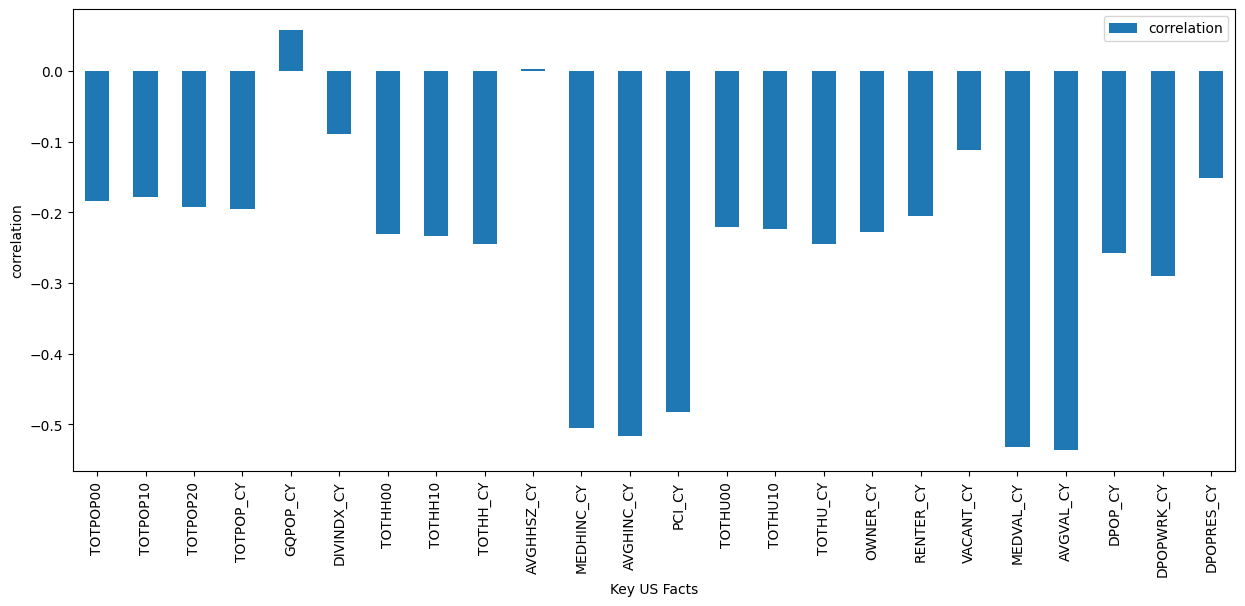

In [13]:
start_column = key_facts.columns.get_loc("HasData") + 1

key_facts_correction = []

for key_fact in range(start_column,len(key_facts.columns)):
    correlation = (key_facts[key_facts.columns[key_fact]].corr(analysis["vaccination_resistance"]))
    key_facts_correction.append([key_facts.columns[key_fact], correlation])

keyfacts_df = pd.DataFrame(key_facts_correction, columns=['fieldName', 'correlation'])
keyfacts_df.head(n=3)

keyfacts_df.plot.bar(x='fieldName',xlabel='Key US Facts',y='correlation',ylabel='correlation',figsize=(15,6))

In [14]:
demographics_variables = usa.data_collections

demographics_variables.head()

,analysisVariable,alias,fieldCategory,vintage
dataCollectionID,,,,
1yearincrements,1yearincrements.AGE0_CY,2023 Population Age <1,2023 Age: 1 Year Increments (Esri),2023
1yearincrements,1yearincrements.AGE1_CY,2023 Population Age 1,2023 Age: 1 Year Increments (Esri),2023
1yearincrements,1yearincrements.AGE2_CY,2023 Population Age 2,2023 Age: 1 Year Increments (Esri),2023
1yearincrements,1yearincrements.AGE3_CY,2023 Population Age 3,2023 Age: 1 Year Increments (Esri),2023
1yearincrements,1yearincrements.AGE4_CY,2023 Population Age 4,2023 Age: 1 Year Increments (Esri),2023


In [15]:
keyfacts_df['analysisVariable'] = 'KeyUSFacts.' + keyfacts_df['fieldName']
result = pd.merge(keyfacts_df, demographics_variables[['analysisVariable','alias']], on='analysisVariable')
result = result.sort_values(by='correlation', ascending=True)
result.head(n=10)

,fieldName,correlation,analysisVariable,alias
20,AVGVAL_CY,-0.536287,KeyUSFacts.AVGVAL_CY,2023 Average Home Value
19,MEDVAL_CY,-0.532608,KeyUSFacts.MEDVAL_CY,2023 Median Home Value
11,AVGHINC_CY,-0.516229,KeyUSFacts.AVGHINC_CY,2023 Average Household Income
10,MEDHINC_CY,-0.505067,KeyUSFacts.MEDHINC_CY,2023 Median Household Income
12,PCI_CY,-0.482561,KeyUSFacts.PCI_CY,2023 Per Capita Income
22,DPOPWRK_CY,-0.290427,KeyUSFacts.DPOPWRK_CY,2023 Daytime Pop: Workers
21,DPOP_CY,-0.257007,KeyUSFacts.DPOP_CY,2023 Total Daytime Population
15,TOTHU_CY,-0.244585,KeyUSFacts.TOTHU_CY,2023 Total Housing Units
8,TOTHH_CY,-0.244365,KeyUSFacts.TOTHH_CY,2023 Total Households
7,TOTHH10,-0.232881,KeyUSFacts.TOTHH10,2010 Total Households


<Axes: xlabel='2022 Average Home Value', ylabel='Vaccination resistance'>

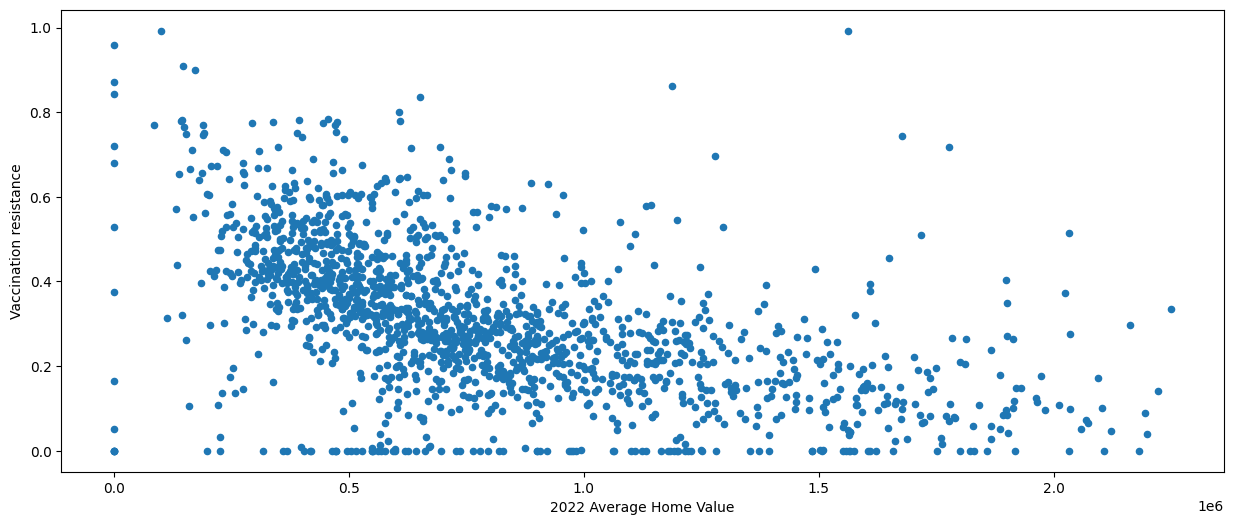

In [16]:
correlation_plot = pd.merge(analysis, key_facts[['zip_code_tabulation_area','AVGVAL_CY']], on='zip_code_tabulation_area')

correlation_plot.plot.scatter(x='AVGVAL_CY',xlabel='2022 Average Home Value', y='vaccination_resistance',ylabel='Vaccination resistance', figsize=(15,6))